## Mount Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Project Directory and Change Path

In [2]:
import os

project_dir = '/content/drive/MyDrive/Skin-Cancer-Detection'
os.chdir(project_dir)

## Data Loading

In [3]:
import pandas as pd

metadata_path = "data/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

print(f"Total images: {len(df)}")
print(f"Unique lesions: {df['lesion_id'].nunique()}")

Total images: 10015
Unique lesions: 7470


## Leakage-Free Train/Val/Test Split (Stratified by Lesion)

In [4]:
from sklearn.model_selection import train_test_split

unique_lesions = df.drop_duplicates(subset=['lesion_id'])

train_lesions, temp_lesions = train_test_split(
    unique_lesions, test_size=0.3, stratify=unique_lesions['dx'], random_state=55
)
val_lesions, test_lesions = train_test_split(
    temp_lesions, test_size=0.5, stratify=temp_lesions['dx'], random_state=55
)

In [5]:
train = df[df['lesion_id'].isin(train_lesions['lesion_id'])].copy()
val = df[df['lesion_id'].isin(val_lesions['lesion_id'])].copy()
test = df[df['lesion_id'].isin(test_lesions['lesion_id'])].copy()

In [6]:
train.to_csv("data/train_meta.csv", index=False)
val.to_csv("data/val_meta.csv", index=False)
test.to_csv("data/test_meta.csv", index=False)

In [7]:
print("Leakage-free Train/Val/Test split completed.")
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
print(f"Train unique lesions: {train['lesion_id'].nunique()}, Val unique: {val['lesion_id'].nunique()}, Test unique: {test['lesion_id'].nunique()}")

Leakage-free Train/Val/Test split completed.
Train: 7019, Val: 1504, Test: 1492
Train unique lesions: 5229, Val unique: 1120, Test unique: 1121


### Undersample NV Class in Train Only

In [8]:
train_class_counts = train['dx'].value_counts()
max_minority = train_class_counts.drop('nv').max()
nv_target = min(train_class_counts['nv'], 2 * max_minority)
print(f"Undersampling NV in train: keep {nv_target} / {train_class_counts['nv']} samples")

Undersampling NV in train: keep 1574 / 4677 samples


In [9]:
nv_lesions = train[train['dx'] == 'nv']['lesion_id'].unique()

avg_imgs_per_nv_lesion = train[train['dx'] == 'nv'].groupby('lesion_id').size().mean()
nv_lesion_count_to_keep = int(nv_target / avg_imgs_per_nv_lesion)
nv_lesions_sampled = pd.Series(nv_lesions).sample(n=nv_lesion_count_to_keep, random_state=42)
undersampled_nv_train = train[train['lesion_id'].isin(nv_lesions_sampled)]

In [10]:
non_nv_train = train[train['dx'] != 'nv']
train_balanced = pd.concat([undersampled_nv_train, non_nv_train], axis=0).reset_index(drop=True)

In [11]:
print("After undersampling NV in train:")
print("Train class distribution:\n", train_balanced['dx'].value_counts())
print(f"Train images: {len(train_balanced)}, Val images: {len(val)}, Test images: {len(test)}")

After undersampling NV in train:
Train class distribution:
 dx
nv       1563
mel       787
bkl       782
bcc       357
akiec     234
vasc      102
df         80
Name: count, dtype: int64
Train images: 3905, Val images: 1504, Test images: 1492


### Save Splits

In [12]:
train_balanced.to_csv("data/train_meta.csv", index=False)
val.to_csv("data/val_meta.csv", index=False)
test.to_csv("data/test_meta.csv", index=False)

print("Splits saved to CSV.")

Splits saved to CSV.


## Visualize Class Distribution by Split

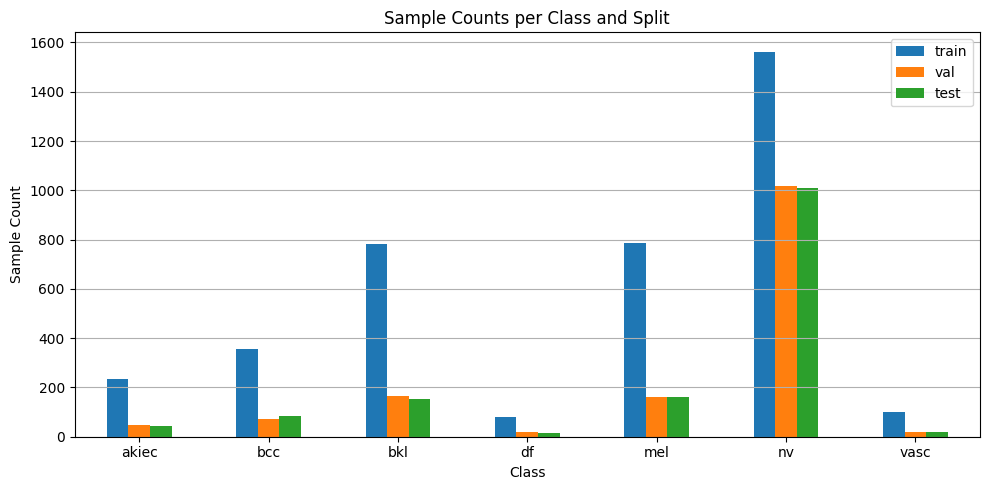

Summary Table:
        train   val  test
dx                      
akiec    234    48    45
bcc      357    72    85
bkl      782   164   153
df        80    19    16
mel      787   163   163
nv      1563  1019  1009
vasc     102    19    21


In [13]:
import matplotlib.pyplot as plt

split_counts = pd.DataFrame({
    'train': train_balanced['dx'].value_counts(),
    'val': val['dx'].value_counts(),
    'test': test['dx'].value_counts()
}).fillna(0).astype(int)

split_counts.plot.bar(rot=0, figsize=(10,5))
plt.title("Sample Counts per Class and Split")
plt.xlabel("Class")
plt.ylabel("Sample Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("Summary Table:\n", split_counts)

## Verify No Lesion Overlap Between Splits

In [15]:
train_lesions = set(train['lesion_id'])
val_lesions = set(val['lesion_id'])
test_lesions = set(test['lesion_id'])

overlap_train_val = train_lesions & val_lesions
overlap_train_test = train_lesions & test_lesions
overlap_val_test = val_lesions & test_lesions

total_overlap = overlap_train_val | overlap_train_test | overlap_val_test

if len(total_overlap) == 0:
    print("No leakage: splits are completely disjoint by lesion.")
else:
    print(f"Leakage detected! {len(total_overlap)} overlapping lesion IDs found:")
    print(total_overlap)

No leakage: splits are completely disjoint by lesion.
